## Setting

In [2]:
%reload_ext autoreload
%autoreload 2

In [93]:
import os

if not os.path.exists("../small_libs"):
    print("the directory small_libs is created")
    !git clone https://github.com/vincentvigon/small_libs
    %cd small_libs
else:
    print("the directory small_libs is updated")
    !git pull https://github.com/vincentvigon/small_libs

the directory small_libs is updated
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 8 (delta 6), reused 8 (delta 6), pack-reused 0
Unpacking objects: 100% (8/8), done.
From https://github.com/vincentvigon/small_libs
 * branch            HEAD       -> FETCH_HEAD
Updating 2ac755f..7695581
Fast-forward
 fourier_neural_operator/test_newton/generate_data_tf.py            | 6 ++----
 fourier_neural_operator/test_newton/run1_newton_with_grid_up.ipynb | 2 +-
 grid_up/grid_up.py                                                 | 2 +-
 3 files changed, 4 insertions(+), 6 deletions(-)


In [94]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/Othercomputers/Mon MacBook Pro/google_saved/PYTHON/small_libs
# %ls

In [95]:
pp=print
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import small_libs.fourier_neural_operator.FNO_1d_plus as fno
#import fourier_neural_operator.test_env as te
import small_libs.grid_up.grid_up as gr
from small_libs.info_helper.info_helper import print_signature
from fourier_neural_operator.test_newton.generate_data_tf import *

# Apprentissage classique

##  Les données

In [96]:
def give_me_newtonData(N):
    return NewtonData(a=0,b=1,N=N,k=lambda u: u ** 4 + 1.0,kind="gauss",BC="dirichlet")

In [48]:
data_creator_train=give_me_newtonData(200)

NewtonData with: nb points=200, kind of data:gauss


In [49]:
X,Y=data_creator_train.make_XY(batch_size=10)

traçage de la fonction generate_XY


* Les 2 channels de `X` correspondent à $f,\alpha$.
* Le channel de `Y` correspond à $U$

In [50]:
X.shape, Y.shape

(TensorShape([10, 200, 2]), TensorShape([10, 200, 1]))

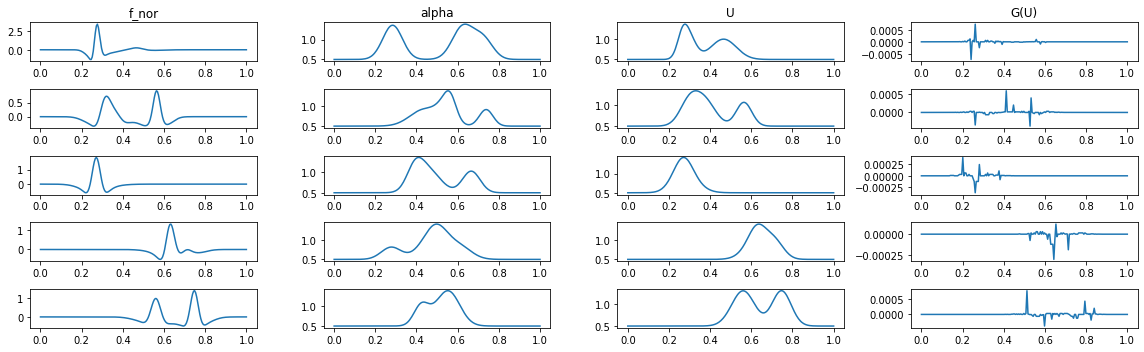

In [51]:
data_creator_train.plot_data(X,Y)

Notons qu'en 32 bit, les résidus on des pointent à 5e-4

## L'agent

Voici la signature du modèle


In [13]:
print_signature(fno.FNO1d_plus.__init__)

self
modes: int
width: int
out_channels: int
nb_layer=4
first_channel_unchanged=False
freq_mix_size=0
pad_prop=0.1
pad_kind='zero_padding'
verbose=False


Quelques explications:

In [14]:
print(fno.FNO1d_plus.__init__.__doc__)


        @param modes:int, number of fourier coef keept
        @param width:int, nb_channels of hidden layers
        @param out_channels:int, dimension of output
        @param nb_layer:int,
        @param first_channel_unchanged:bool, if True, at the beginning of the training, the first channel of each hidden layer is simply the spectrum
        @param freq_mix_size:int, size of the convolutionnal kernel applyiend the frequency layers
        @param pad_prop:float, the padding is int(pad_prof*signal_size) at each border
        @param pad_kind:string, kind of padding. Eg: neumann_padding, smooth_padding,zero_padding
        @param verbose:bool, if True, more message are printed
        


Voici la signature de l'agent, qui crée le modèle et l'entraine sur step.

In [41]:
print_signature(AgentNewton.__init__)

self
name_of_losses
modes
width
nb_layer
first_channel_unchanged
freq_mix_size
pad_prop
pad_kind
batch_size
only_one_optimizer
lr


In [84]:
name_of_losses = ["U", "D", "diffusion"] 
#l'erreur de "residues" est proche de celle de diffusion
#Mais l'ajout de ce terme perturbe l'apprentissage

agent= AgentNewton(
    name_of_losses=name_of_losses,
    modes=20,
    width=20,
    nb_layer=4,
    first_channel_unchanged=True,
    freq_mix_size=5,
    pad_prop=0,
    pad_kind="no_padding",
    batch_size=64,
    only_one_optimizer=False,
    lr=1e-3
)

data=give_me_newtonData(N=200)

losses_hist = {name: [] for name in name_of_losses}



NewtonData with: nb points=200, kind of data:gauss


In [85]:
for i in range(1000):
    loss, losses = agent.train_step_with_details(data)
    for name in name_of_losses:
        losses_hist[name].append(losses[name])
    if i % 50 == 0:
        print(loss.numpy())

traçage de la fonction generate_XY
7.4858184
0.34323102
0.16845743
0.11150266
0.14915392
0.06296505
0.050001327
0.025748728
0.026718851
0.082678564
0.018327598
0.011579809
0.023530472
0.034332782
0.016309045
0.00792767
0.007850437
0.01267458
0.008479107
0.006097865


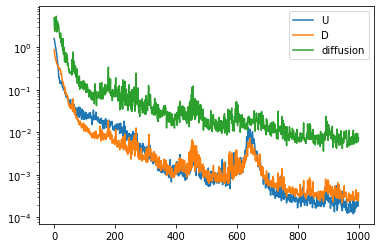

In [86]:
for name in name_of_losses:
    plt.plot(losses_hist[name],label=name)

plt.yscale("log")
plt.legend()
plt.show()

## Test dans la résolution de l'entrainement

In [89]:
def display_results(data_creator,model):

    nb=8
    fig,axs=plt.subplots(nb,4,sharex="all",figsize=(20,2*nb))
    X,Y=data_creator.make_XY(nb)
    Y_pred = model.call(X)
    f=X[:,:,0]*data_creator.normalisation_for_f
    alpha=X[:,:,1]

    res=data_creator.G2(X,Y)
    res_pred=data_creator.G2(X,Y_pred)
    for i in range(nb):
        axs[i,0].plot(f[i,:])
        axs[i,1].plot(alpha[i,:])
        axs[i,2].plot(Y[i,:,0],label="true")
        axs[i,2].plot(Y_pred[i,:,0],label="pred")
        axs[i,3].plot(res[i,:],label="true")
        axs[i,3].plot(res_pred[i,:],label="pred")

    axs[0,0].set_title("f")
    axs[0,1].set_title("alpha")
    axs[0,2].set_title("U")
    axs[0,3].set_title("residues")

    axs[0,2].legend()

    plt.show()


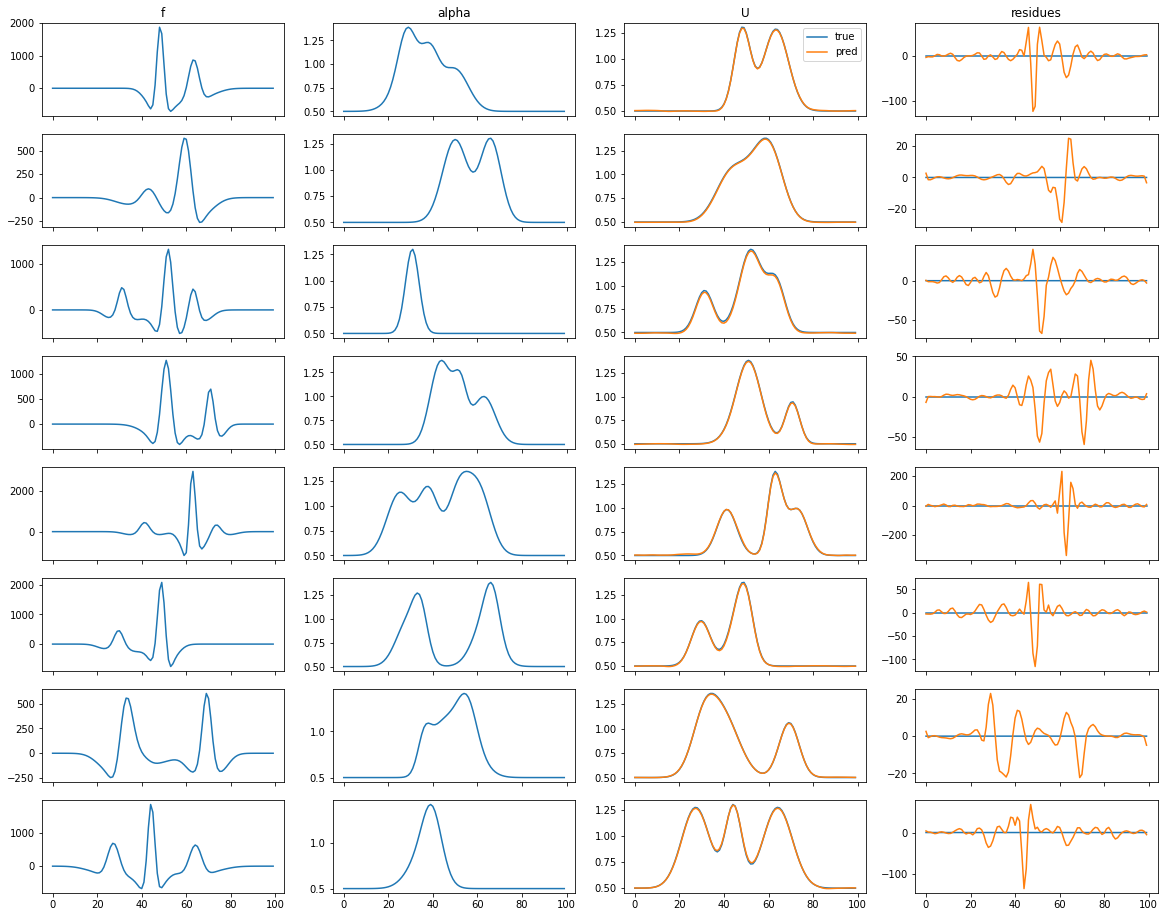

In [90]:
display_results(data_creator_train,agent.model)

## Test avec résolution supèrieure

NewtonData with: nb points=300, kind of data:gauss
traçage de la fonction generate_XY


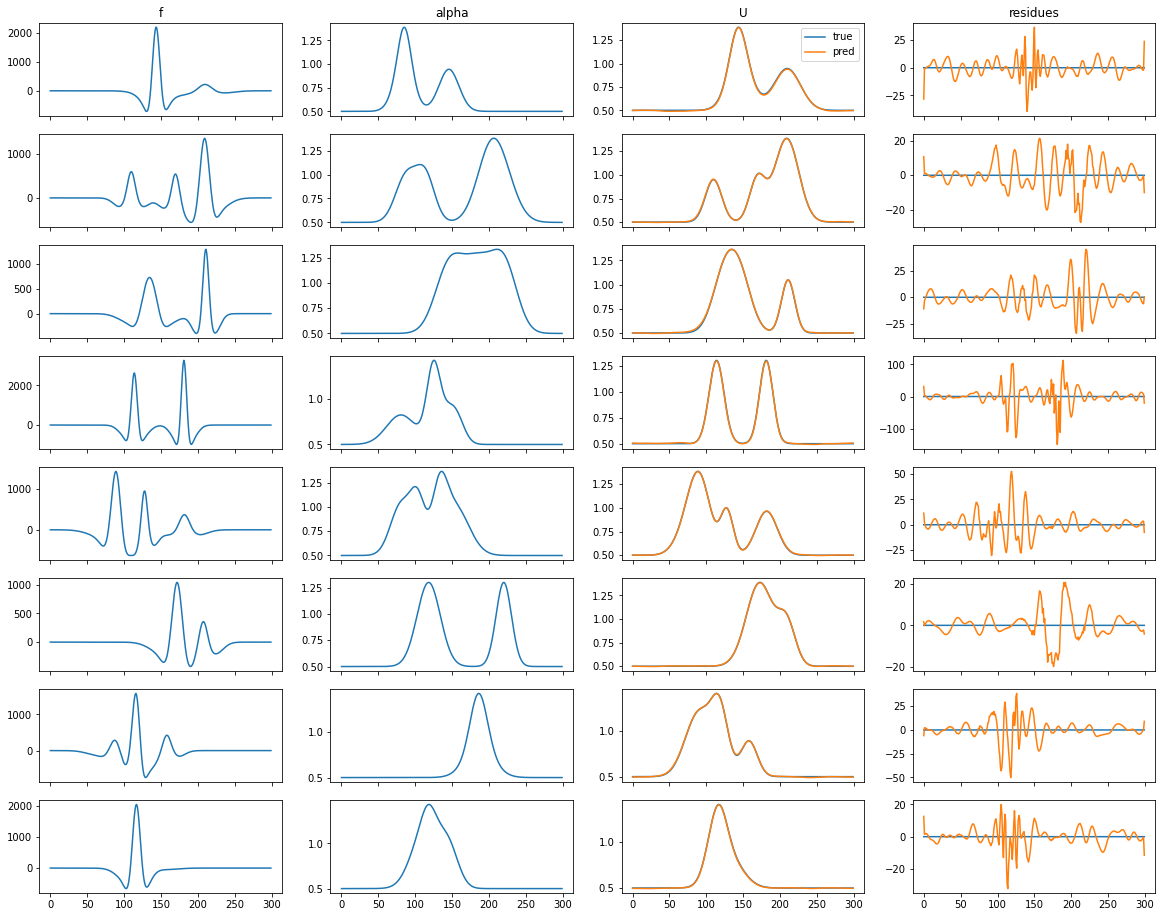

In [91]:
data_creator_test=give_me_newtonData(300)
display_results(data_creator_test,agent.model)

## Test avec résolution inférieure

NewtonData with: nb points=100, kind of data:gauss
traçage de la fonction generate_XY


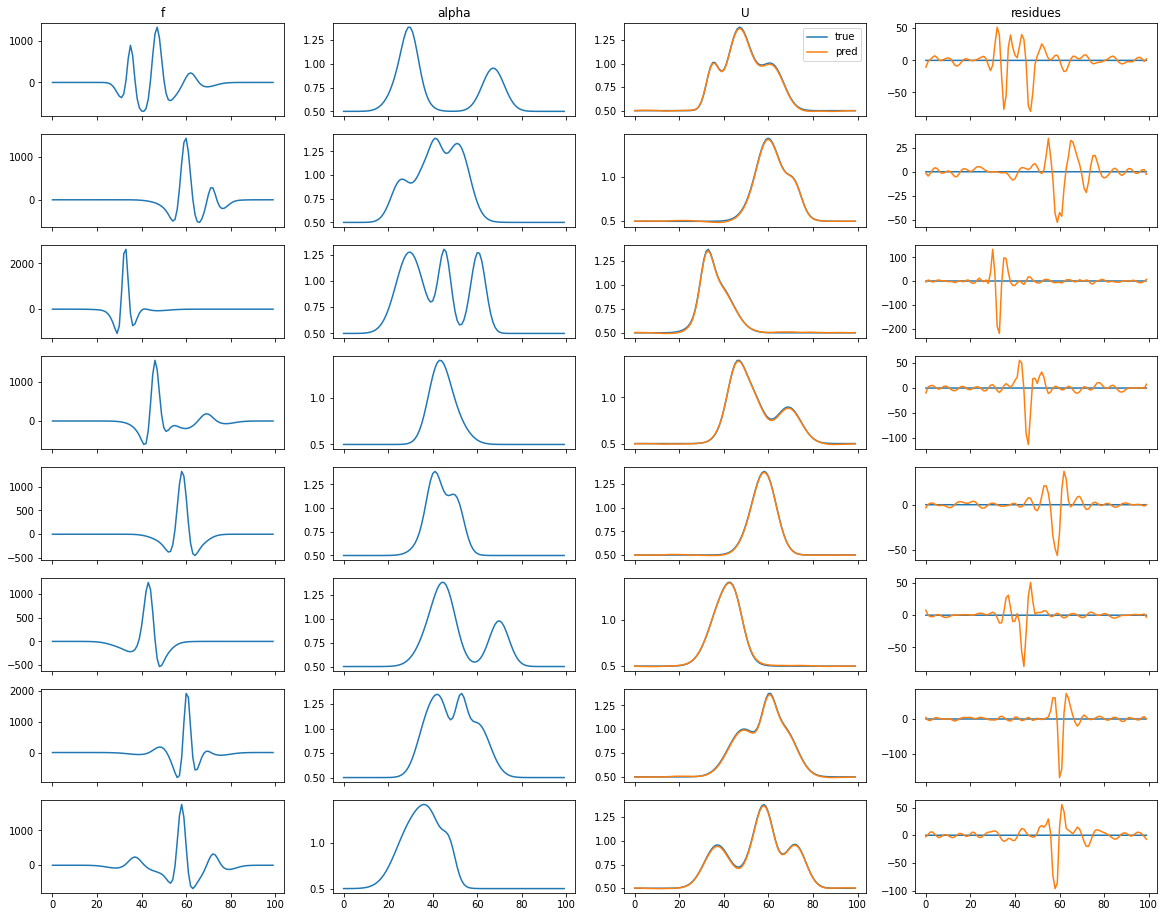

In [92]:
data_creator_test=data_creator_train=give_me_newtonData(100)
display_results(data_creator_test,agent.model)

# Apprentissage multiple avec `grid_up`

Nous allons faire varier un à un les paramètres du FNO et tester sur différentes résolution, en utilisant `grid_up`


Sur des données périodiques, le padding est inutile. On le vérifiera en faisant varier `pad_prop`

Mais du coup on ne testera pas les différents `pad_kind` 


In [99]:
def make_gridup():
    resolutions_train=[200]
    resolutions_test=[64,100,150,200,250,300,400]

    creator_train={nx:give_me_newtonData(nx) for nx in resolutions_train}
    creator_test= {nx:give_me_newtonData(nx) for nx in resolutions_test}


    fixed_params = {
        "name_of_losses":["U","D","diffusion"],
        "modes":30,
        "width":20,
        "nb_layer":4,
        "first_channel_unchanged":True,
        "freq_mix_size":5,
        "pad_prop":0,
        "pad_kind":"no_padding",
        "batch_size":64,
        "only_one_optimizer":False,
        "lr":1e-3
    }

    pad_kinds=[
        'no_padding',
        #'zero_padding',
        'dirichlet_padding', 
        'neumann_padding', 
        'smooth_padding', 
        #'periodic_padding', 
        'smooth_periodizing_padding', 
        'linear_periodizing_padding']

    
    varying_params = {
        "name_of_losses":[["U","D","diffusion"],["U","D"],["U"]],
        "modes":[10,20,30],
        "width":[10,20,30,50],
        "nb_layer":[2,3,4,5],
        "first_channel_unchanged":[True,False],
        "freq_mix_size":[0,5,9],
        "pad_prop":[0,0.02,0.05,0.1,0.2],
        "pad_kind":pad_kinds,
        "batch_size":[64,128,256,512],
        "only_one_optimizer":[True,False],
        "lr":[1e-2,1e-3,1e-4]
    }


    gridup=gr.GridUp(
        AgentNewton,
        creator_train,
        creator_test,
        fixed_params=fixed_params,
        varying_params=varying_params,
        minutes=1,
        verbose=False
    )
    return gridup

gridup=make_gridup()

NewtonData with: nb points=200, kind of data:gauss
NewtonData with: nb points=64, kind of data:gauss
NewtonData with: nb points=100, kind of data:gauss
NewtonData with: nb points=150, kind of data:gauss
NewtonData with: nb points=200, kind of data:gauss
NewtonData with: nb points=250, kind of data:gauss
NewtonData with: nb points=300, kind of data:gauss
NewtonData with: nb points=400, kind of data:gauss


## Paramètres lié à la loss 

## Paramètres du modèle

In [100]:
gridup.watch_param("first_channel_unchanged");

Look for agent.first_channel_unchanged=[True, False]. Train with data-cases:[200], Test with data-cases:[64, 100, 150, 200, 250, 300, 400]
Other parameters are: [('name_of_losses', ['U', 'D', 'diffusion']), ('modes', 30), ('width', 20), ('nb_layer', 4), ('freq_mix_size', 5), ('pad_prop', 0), ('pad_kind', 'no_padding'), ('batch_size', 64), ('only_one_optimizer', False), ('lr', 0.001)]
traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY


traçage de la fonction generate_XY


traçage de la fonction generate_XY


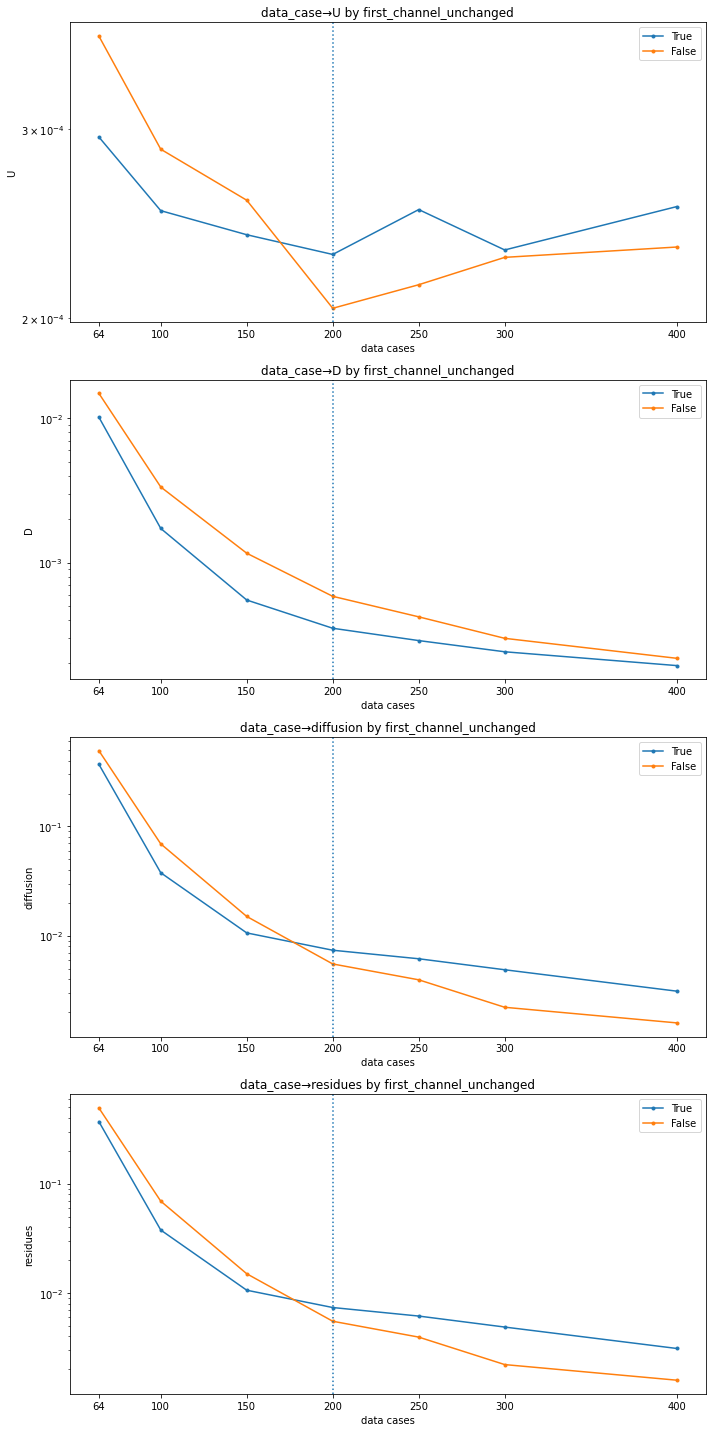

In [102]:
gridup.plot_last_result();

traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY


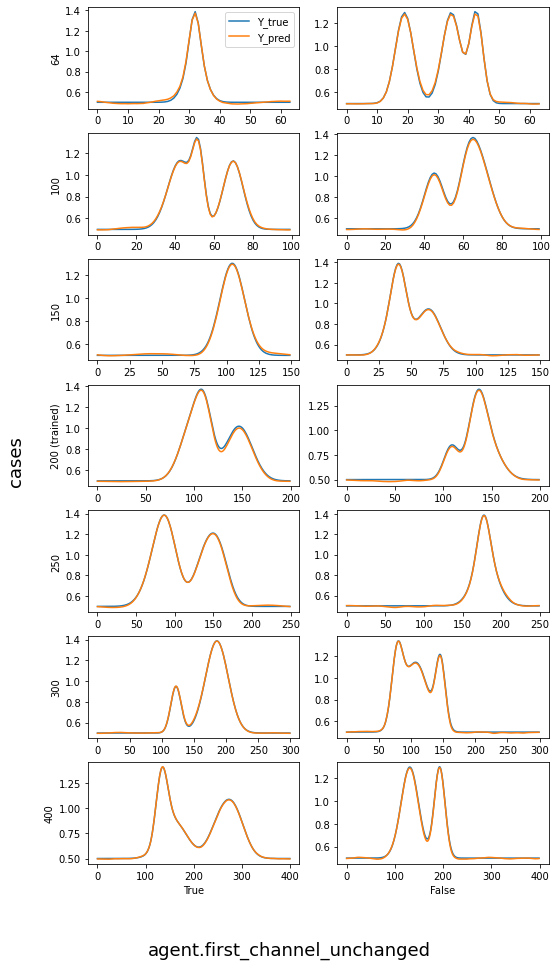

In [103]:
gridup.plot_prediction();

In [ ]:
testor.watch_param("pad_prop");

Look for model.pad_prop=[0, 0.02, 0.05, 0.1, 0.2]. Train with data-cases:[100, 150], Test with data-cases:[50, 75, 100, 125, 150, 175, 200]
Other parameters are: [('first_channel_unchanged', False), ('freq_mix_size', 5), ('pad_kind', 'smooth_padding'), ('modes', 20), ('width', 15), ('nb_layer', 4), ('out_channels', 1)]


TypeError: ignored

In [ ]:
testor.plot_last_result();

In [ ]:
testor.plot_prediction();

In [ ]:
testor.watch_param("freq_mix_size");

In [ ]:
testor.plot_last_result();

In [ ]:
testor.plot_prediction();

In [ ]:
testor.watch_param("modes");

In [ ]:
testor.plot_last_result();

In [ ]:
testor.plot_prediction();

In [ ]:
testor.watch_param("width");

In [ ]:
testor.plot_last_result();

In [ ]:
testor.plot_prediction();

In [ ]:
testor.watch_param("nb_layer");

In [ ]:
testor.plot_last_result();

In [ ]:
testor.plot_prediction();